In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
import tensorflow as tf

In [2]:
bm = pd.read_csv('bigMart_train.csv')

In [3]:
bm.head(4)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800


In [4]:
bm['Item_Weight'] = bm['Item_Weight'].fillna(bm['Item_Weight'].mean())

In [5]:
from sklearn.preprocessing import LabelEncoder

def encode(dataframe, attr_list):
  le = LabelEncoder()
  for a in attr_list:
    dataframe[a] = le.fit_transform(dataframe[a].astype(str))

In [6]:
encode(bm, ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'])

In [7]:
import seaborn as sb

In [8]:
def remove_skewness(bm):
    for i in bm.describe():
        if i not in ['Item_Identifier', 'Outlet_Identifier']:
            if bm[i].skew() >= 1.0:
                bm[i] = np.log1p(bm[i])

In [9]:
remove_skewness(bm)

In [10]:
import matplotlib.pyplot as plt

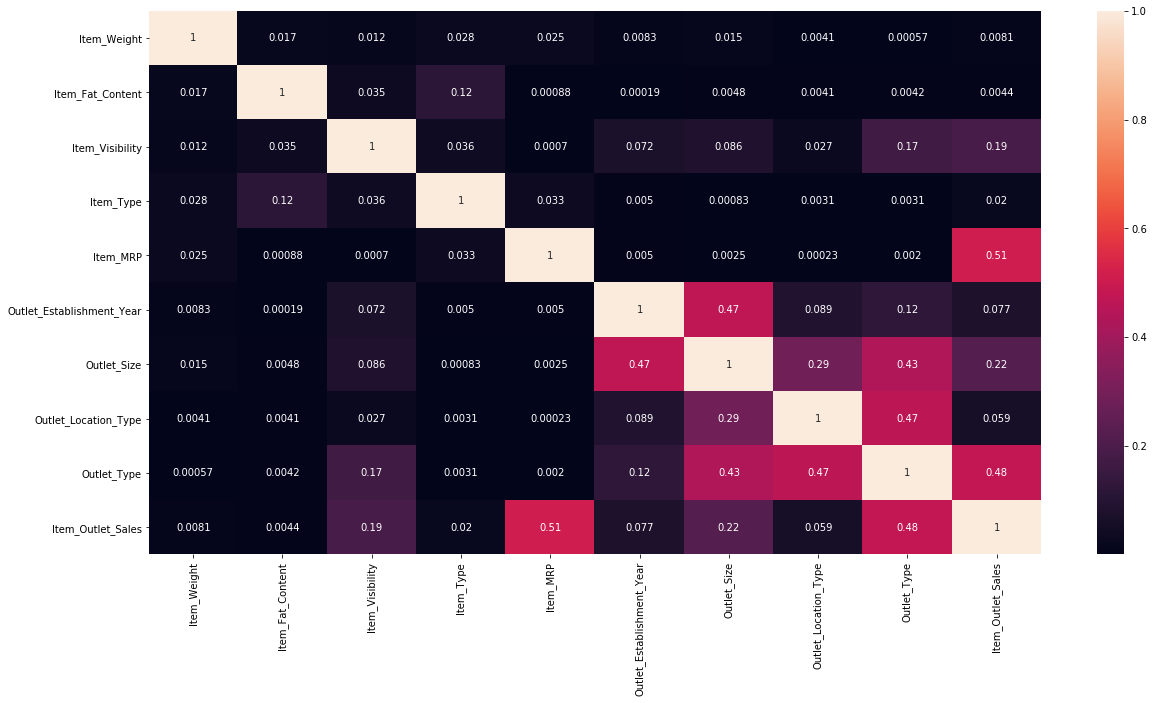

In [11]:
plt.figure(figsize=(20, 10))
sb.heatmap(bm.corr().abs(), annot=True)

In [12]:
to_keep = ['Item_MRP', 'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year', 'Item_Visibility', 'Item_Outlet_Sales']

In [13]:
Y = bm['Item_Outlet_Sales']
X = bm[to_keep]

In [14]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33)

Y_train = Y_train.values.reshape(-1, 1)
Y_test = Y_test.values.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler
scalerXtrain = MinMaxScaler()
scalerXtest = MinMaxScaler()
scalerYtrain = MinMaxScaler()
scalerYtest = MinMaxScaler()

X_train = scalerXtrain.fit_transform(X_train)
X_test = scalerXtest.fit_transform(X_test)
Y_train = scalerYtrain.fit_transform(Y_train)
Y_test = scalerYtest.fit_transform(Y_test)

In [15]:
num_features = X_train.shape[1]
with tf.name_scope("io"):
    inputs = tf.placeholder(tf.float32, shape=[None, num_features], name="x_train")
    outputs = tf.placeholder(tf.float32, shape=[None, 1], name="y_train")

In [16]:
with tf.name_scope("layers"):
    layers = [num_features, 4, 1]
    W = []
    b = []
  
    for i in range(1, len(layers)):
        W.append(tf.Variable(tf.random_normal([layers[i-1], layers[i]], 0, 0.1, dtype=tf.float32), name="W%d" % i))
        b.append(tf.Variable(tf.zeros([layers[i]], dtype=tf.float32), name="b%d" % i))

In [17]:
def model(inputs, W, b):
  lastY = inputs
  for i, (Wi, bi) in enumerate(zip(W, b)):
    y = tf.add(tf.matmul(lastY, W[i]), b[i])  
    if i == len(b)-1:
      return tf.nn.sigmoid(y)
    
    lastY = tf.nn.relu(y)

In [18]:
with tf.name_scope("ops"):
    yout = model(inputs, W, b)
  
    cost_op = tf.reduce_mean(tf.square(yout - outputs))
    tf.summary.scalar("mse", cost_op)
    summ = tf.summary.merge_all()
  
    alpha = 0.001
    train = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost_op)

In [19]:
bm_test = pd.read_csv('bigMart_test.csv')

In [20]:
bm_test.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [21]:
Y_test.shape

(2813, 1)

In [22]:
# train
batch_size = X_train.shape[0]
test_batch_size = 1
num_batches = int(X_train.shape[0] / batch_size)
test_num_batches = int(X_test.shape[0] / test_batch_size)
total_epochs = 20000
epoch = 0


costs = []

sess = tf.Session()

with sess.as_default():
    sess.run(tf.global_variables_initializer())

    writer = tf.summary.FileWriter("/tmp/bigmart/5")
    writer.add_graph(sess.graph)

    while True:
        cost = 0.0
        for b in range(num_batches):
            x_batch = X_train[b*batch_size : (b+1)*batch_size]
            y_batch = Y_train[b*batch_size : (b+1)*batch_size]

            sess.run(train, feed_dict={inputs: x_batch, outputs: y_batch})

            c = sess.run(cost_op, feed_dict={inputs: x_batch, outputs: y_batch})
            s = sess.run(summ, feed_dict={inputs: x_batch, outputs: y_batch})
            writer.add_summary(s, epoch)
            cost += c
        cost /= num_batches
        costs.append(cost)

        epoch += 1
        if epoch % 1000 == 0:
            print("Cost after %d epochs is %1.8f" % (epoch, cost))
        if epoch >= total_epochs:
            break
        
    print( "Test Cost =", sess.run(cost_op, feed_dict={inputs: X_test, outputs: Y_test}))
    pred_y = sess.run(yout, feed_dict={inputs: X_test, outputs: Y_test})
    
    print("\nA few predictions\nReal\tPredicted\n")
    
    # inverse scaler to see appropriate outlet sales
    Y_test_new = scalerYtest.inverse_transform(Y_test)
    pred_y_new = scalerYtest.inverse_transform(pred_y)
    for (y, yhat) in list(zip(Y_test_new, pred_y_new))[0:10]:
        print("%1.6f\t%1.6f" % (y, yhat))

Cost after 1000 epochs is 0.00919786
Cost after 2000 epochs is 0.00195092
Cost after 3000 epochs is 0.00076952
Cost after 4000 epochs is 0.00041125
Cost after 5000 epochs is 0.00025974
Cost after 6000 epochs is 0.00017641
Cost after 7000 epochs is 0.00012241
Cost after 8000 epochs is 0.00009210
Cost after 9000 epochs is 0.00008103
Cost after 10000 epochs is 0.00007822
Cost after 11000 epochs is 0.00007760
Cost after 12000 epochs is 0.00007756
Cost after 13000 epochs is 0.00007756
Cost after 14000 epochs is 0.00007756
Cost after 15000 epochs is 0.00007756
Cost after 16000 epochs is 0.00007756
Cost after 17000 epochs is 0.00007756
Cost after 18000 epochs is 0.00007756
Cost after 19000 epochs is 0.00007756
Cost after 20000 epochs is 0.00007756
Test Cost = 7.39018e-05

A few predictions
Real	Predicted

8.485777	8.510478
8.505910	8.532222
7.627055	7.646801
8.642878	8.669118
7.374582	7.402540
8.091754	8.058959
7.842940	7.846590
8.524059	8.562739
6.461731	6.426769
7.441583	7.466608
